In [1]:
%cd super-resolution

/home/samx/Workspace/SR-GAN-Edge-TPU/super-resolution


In [2]:
import os
import matplotlib.pyplot as plt

from data import DIV2K
from model.srgan import generator, discriminator
from train import SrganTrainer, SrganGeneratorTrainer

%matplotlib inline

In [3]:
# Location of model weights (needed for demo)
weights_dir = 'weights/srgan'
weights_file = lambda filename: os.path.join(weights_dir, filename)

os.makedirs(weights_dir, exist_ok=True)

In [4]:
div2k_train = DIV2K(scale=4, subset='train', downgrade='bicubic')
div2k_valid = DIV2K(scale=4, subset='valid', downgrade='bicubic')



In [5]:
train_ds = div2k_train.dataset(batch_size=16, random_transform=True)
valid_ds = div2k_valid.dataset(batch_size=16, random_transform=True, repeat_count=1)

2021-11-14 18:56:19.197681: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-14 18:56:19.219030: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-14 18:56:19.219186: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-14 18:56:19.219554: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [6]:
from model.srgan import generator
from train import SrganGeneratorTrainer

# Create a training context for the generator (SRResNet) alone.
#pre_trainer = SrganGeneratorTrainer(model=generator(), checkpoint_dir=f'.ckpt/pre_generator')

# Pre-train the generator with 1,000,000 steps (100,000 works fine too). 
#pre_trainer.train(train_ds, valid_ds.take(10), steps=100000, evaluate_every=5000)

# Save weights of pre-trained generator (needed for fine-tuning with GAN).
#pre_trainer.model.save_weights('weights/srgan/pre_generator.h5')

In [7]:
from model.srgan import generator, discriminator
from train import SrganTrainer

# Create a new generator and init it with pre-trained weights.
gan_generator = generator()
gan_generator.load_weights('weights/srgan/pre_generator.h5')

# Create a training context for the GAN (generator + discriminator).
gan_trainer = SrganTrainer(generator=gan_generator, discriminator=discriminator())

# Train the GAN with 200,000 steps.
#gan_trainer.train(train_ds, steps=200_000, evaluate_every=5000)

# Save weights of generator and discriminator.
#gan_trainer.generator.save_weights('weights/srgan/gan_generator.h5')
#gan_trainer.discriminator.save_weights('weights/srgan/gan_discriminator.h5')

2021-11-14 18:56:21.546822: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8300
2021-11-14 18:56:21.908702: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


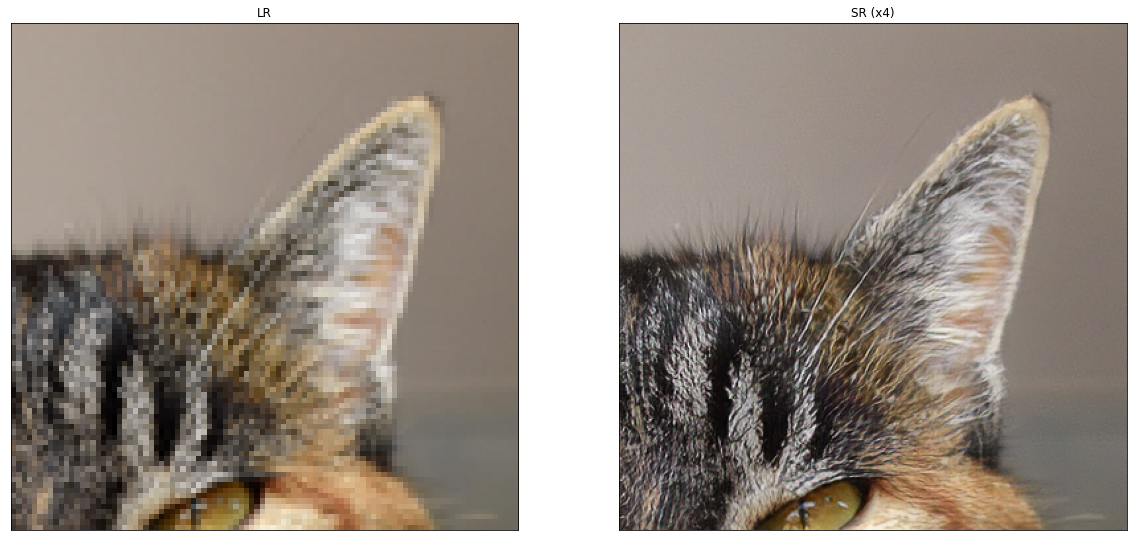

In [8]:
from model.srgan import generator
from model import resolve_single
from utils import load_image, plot_sample
import tensorflow as tf

model = generator()
model.load_weights('weights/srgan/gan_generator.h5')


lr = load_image('demo/0869x4-crop.png')
lr_reshape = tf.image.resize(lr, [96, 96], method='bicubic')
#lr_reshape = lr
#print(lr.shape)
sr = resolve_single(model, lr_reshape)



plot_sample(lr_reshape/255.0, sr)

In [9]:
import tensorflow as tf
assert float(tf.__version__[:3]) >= 2.3
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
tflite_model_size = open("srgan.tflite", "wb").write(tflite_model)

2021-11-14 18:56:27.266777: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /tmp/tmpqg5a1m_0/assets


2021-11-14 18:56:36.214315: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:363] Ignored output_format.
2021-11-14 18:56:36.214334: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:366] Ignored drop_control_dependency.
2021-11-14 18:56:36.214881: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmpqg5a1m_0
2021-11-14 18:56:36.231164: I tensorflow/cc/saved_model/reader.cc:107] Reading meta graph with tags { serve }
2021-11-14 18:56:36.231174: I tensorflow/cc/saved_model/reader.cc:148] Reading SavedModel debug info (if present) from: /tmp/tmpqg5a1m_0
2021-11-14 18:56:36.301002: I tensorflow/cc/saved_model/loader.cc:210] Restoring SavedModel bundle.
2021-11-14 18:56:36.574671: I tensorflow/cc/saved_model/loader.cc:194] Running initialization op on SavedModel bundle at path: /tmp/tmpqg5a1m_0
2021-11-14 18:56:36.691432: I tensorflow/cc/saved_model/loader.cc:283] SavedModel load for tags { serve }; Status: success: OK. Took 476552

In [10]:
# A generator that provides a representative dataset


def representative_data_gen():
    ds = div2k_train.lr_dataset()
    ds = ds.take(100)
    for image in ds:
        #mage = tf.image.resize(image, [image.shape[0], image.shape[1]])
        image = tf.image.resize(image, [96, 96], method='bicubic')
        image = tf.cast(image / 255., tf.float32)
        image = tf.expand_dims(image, 0)
        yield [image]


#ds = div2k_train.lr_dataset().take(1)
#for image in ds:
#    #print(np.max(image))
#    plt.imshow(image)
#    image = tf.image.resize(image, [24, 24], method='bicubic')
#    image = tf.cast(image / 255., tf.float32)
#    plt.imshow(image)



In [11]:
import tensorflow as tf
assert float(tf.__version__[:3]) >= 2.3

import os
import numpy as np
import matplotlib.pyplot as plt

converter = tf.lite.TFLiteConverter.from_keras_model(model)
# This enables quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# This sets the representative dataset for quantization
converter.representative_dataset = representative_data_gen
# This ensures that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# For full integer quantization, though supported types defaults to int8 only, we explicitly declare it for clarity.
converter.target_spec.supported_types = [tf.int8]
# These set the input and output tensors to uint8 (added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
tflite_model = converter.convert()

tflite_model_size = open("srgan_quant_2.tflite", "wb").write(tflite_model)
print("Quantized model is %d bytes" % tflite_model_size)

INFO:tensorflow:Assets written to: /tmp/tmpkm57_c9v/assets


INFO:tensorflow:Assets written to: /tmp/tmpkm57_c9v/assets
2021-11-14 18:56:49.318351: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:363] Ignored output_format.
2021-11-14 18:56:49.318370: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:366] Ignored drop_control_dependency.
2021-11-14 18:56:49.318508: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmpkm57_c9v
2021-11-14 18:56:49.335295: I tensorflow/cc/saved_model/reader.cc:107] Reading meta graph with tags { serve }
2021-11-14 18:56:49.335308: I tensorflow/cc/saved_model/reader.cc:148] Reading SavedModel debug info (if present) from: /tmp/tmpkm57_c9v
2021-11-14 18:56:49.407005: I tensorflow/cc/saved_model/loader.cc:210] Restoring SavedModel bundle.
2021-11-14 18:56:49.661319: I tensorflow/cc/saved_model/loader.cc:194] Running initialization op on SavedModel bundle at path: /tmp/tmpkm57_c9v
2021-11-14 18:56:49.778887: I tensorflow/cc/saved_model/loader.cc:283] SavedMode

Quantized model is 1656888 bytes


In [12]:
import tensorflow as tf
assert float(tf.__version__[:3]) >= 2.3

import os
import numpy as np
import matplotlib.pyplot as plt
def set_input_tensor(interpreter, input):
  input_details = interpreter.get_input_details()[0]
  tensor_index = input_details['index']

  shape = tf.expand_dims(input, 0)
  interpreter.resize_tensor_input(tensor_index, shape.shape);         # change input size dynamically
  interpreter.allocate_tensors()
  
  input_tensor = interpreter.tensor(tensor_index)()[0]
  # Inputs for the TFLite model must be uint8, so we quantize our input data.
  # NOTE: This step is necessary only because we're receiving input data from
  # ImageDataGenerator, which rescaled all image data to float [0,1]. When using
  # bitmap inputs, they're already uint8 [0,255] so this can be replaced with:
  #input_tensor[:, :] = input
  #print(input_tensor.shape)
  scale, zero_point = input_details['quantization']
  
  input = np.float32(input)/255.0
  input_tensor[:, :] = np.uint8(input / scale + zero_point)

def lr2sr(interpreter, input):
  set_input_tensor(interpreter, input)
  interpreter.invoke()
  output_details = interpreter.get_output_details()[0]
  output = interpreter.get_tensor(output_details['index'])[0]
  
  # Outputs from the TFLite model are uint8, so we dequantize the results:
  scale, zero_point = output_details['quantization']
  output = ((scale * (output - zero_point))+1)*127.5
    
  output = tf.cast(output, tf.uint8)
  # print(output)
  return output

interpreter = tf.lite.Interpreter('srgan_quant_2.tflite')
interpreter.allocate_tensors()

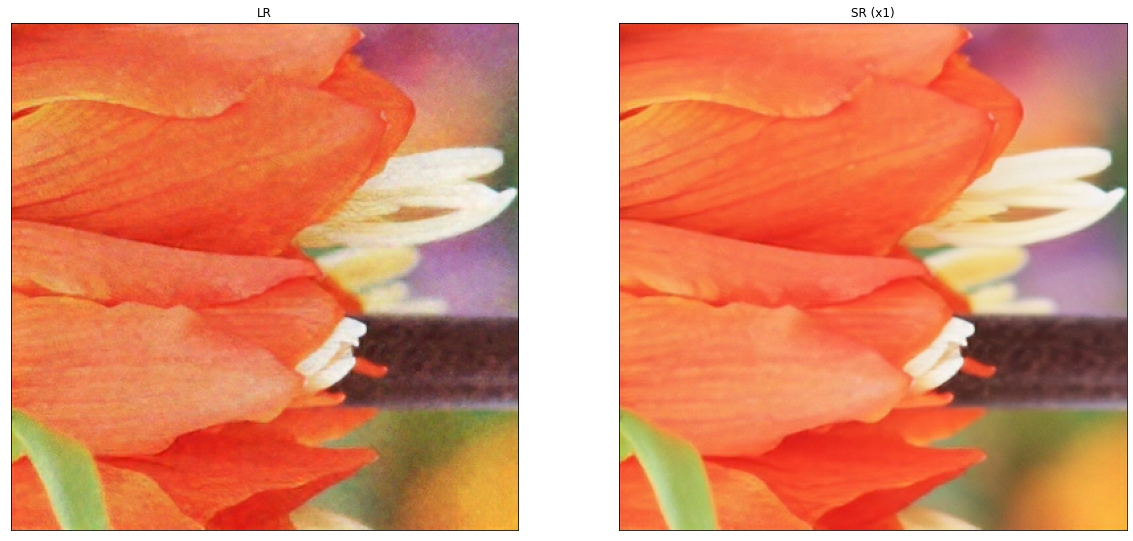

In [13]:
#dd = div2k_train.hr_dataset().take(1)
dd = valid_ds.take(1)
for image, label in dd:
    lr = image[2]
    hr = label[2]


sr_raw = resolve_single(model, lr)
sr_q = lr2sr(interpreter, lr)

plot_sample(sr_q, sr_raw)

In [14]:
psnr_raw = tf.image.psnr(sr_raw, hr, max_val=255)
psnr_quant = tf.image.psnr(sr_q, hr, max_val=255)
print(psnr_raw)
print(psnr_quant)

tf.Tensor(33.071827, shape=(), dtype=float32)
tf.Tensor(26.780037, shape=(), dtype=float32)


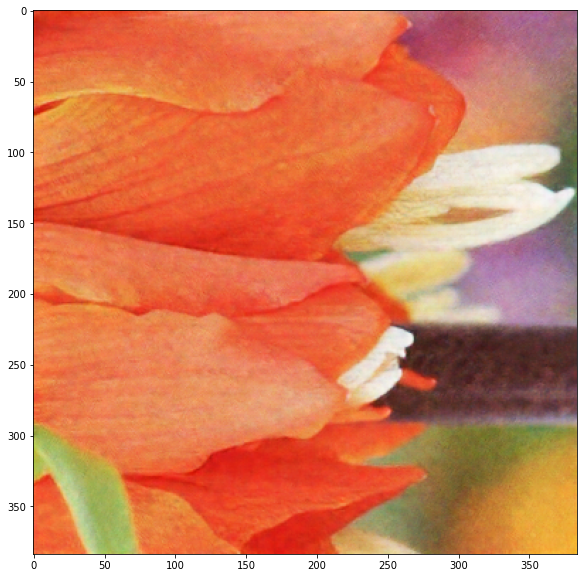

In [15]:
plt.figure(figsize=(20, 10))
plt.imshow(sr_q)

! curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -

! echo "deb https://packages.cloud.google.com/apt coral-edgetpu-stable main" | sudo tee /etc/apt/sources.list.d/coral-edgetpu.list

! sudo apt-get update

! sudo apt-get install edgetpu-compiler	

In [16]:
! edgetpu_compiler -sa srgan_quant_2.tflite

Edge TPU Compiler version 16.0.384591198
Started a compilation timeout timer of 180 seconds.

Model compiled successfully in 1604 ms.

Input model: srgan_quant_2.tflite
Input size: 1.58MiB
Output model: srgan_quant_2_edgetpu.tflite
Output size: 2.57MiB
On-chip memory used for caching model parameters: 1.42MiB
On-chip memory remaining for caching model parameters: 6.25KiB
Off-chip memory used for streaming uncached model parameters: 150.50KiB
Number of Edge TPU subgraphs: 3
Total number of operations: 82
Operation log: srgan_quant_2_edgetpu.log

Model successfully compiled but not all operations are supported by the Edge TPU. A percentage of the model will instead run on the CPU, which is slower. If possible, consider updating your model to use only operations supported by the Edge TPU. For details, visit g.co/coral/model-reqs.
Number of operations that will run on Edge TPU: 76
Number of operations that will run on CPU: 6

Operator                       Count      Status

QUANTIZE      

(24, 24, 3)
(96, 96, 3)


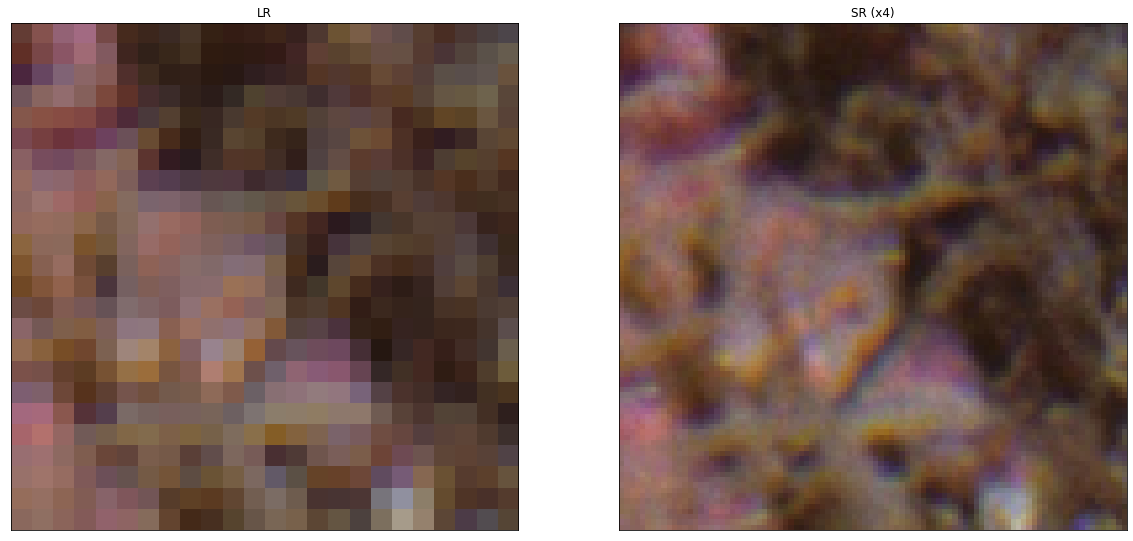

In [23]:
dd = train_ds.take(1)

for image, label in dd:
    plot_sample(image[0], label[0])
    print(image[0].shape)
    print(label[0].shape)
  